# Series temporales

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn import datasets

# 1. Series temporales

En este primer ejercicio trabajaremos las series temporales. Para ello, usaremos el dataset *AirPassangers* que contiene información del número de vuelos que se realizaron a lo largo de muchos años.

Empezaremos leyendo los datos y observando gráficamente su distribución. Como se puede apreciar es un claro caso de serie temporal, con heterocedasticidad, tendencia, periodo y ruido. A lo largo de este ejercicio trataremos cada uno de estos puntos.

In [2]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', header=0)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

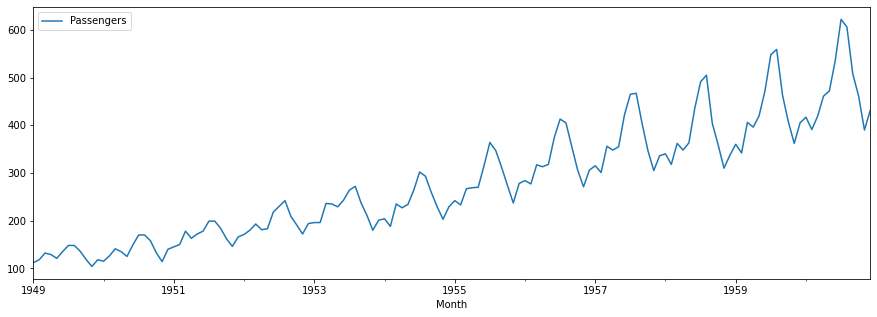

In [3]:
data.plot(figsize=(15, 5))

Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [4]:
TEST_SIZE = 24
train, test = data.iloc[:-TEST_SIZE].to_numpy(), data.iloc[-TEST_SIZE:].to_numpy()
x_train, x_test = np.arange(train.shape[0]), np.arange(train.shape[0], data.shape[0])
train.shape, x_train.shape, test.shape, x_test.shape

((120, 1), (120,), (24, 1), (24,))

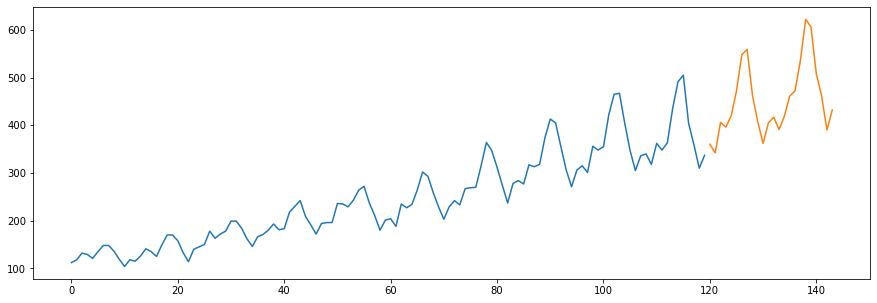

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)
plt.show()

In [6]:
df_train = pd.DataFrame({'passengers': [int(i) for i in train]}, index=x_train)
df_train.tail()

,passengers
115,505
116,404
117,359
118,310
119,337


<AxesSubplot:>

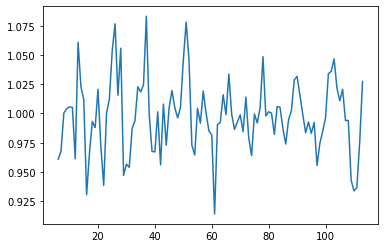

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_train.passengers, model='multiplicative', period=12)
# trend=result.trend
trend=result.resid
trend.plot()

## 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos heterocedasticidad, ya que la amplitud de onda varía con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

In [8]:
df_train['no_heterocedasticidad'] = np.log(df_train.passengers)

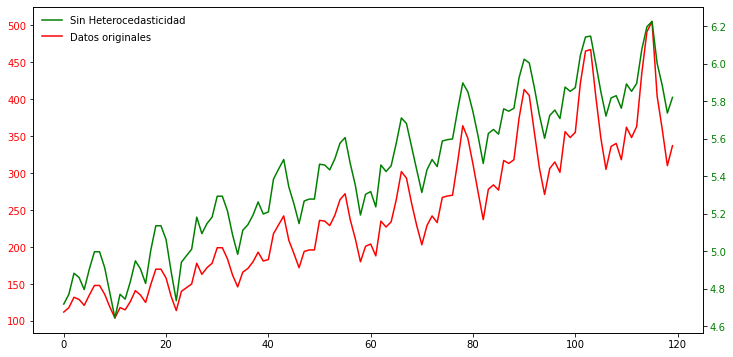

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_train.passengers, color = 'red', label='Datos originales')
ax.tick_params(axis='y', labelcolor='red')

ax_log = ax.twinx()
ax_log.plot(df_train.no_heterocedasticidad, color='green', label = 'Sin Heterocedasticidad')
# ax_log.set_yscale('log')
ax_log.tick_params(axis='y', labelcolor='green')

ax_log.legend(frameon=False)
ax.legend(frameon=False, loc='upper left', bbox_to_anchor = (0,0.95))
plt.show()

### 1.1.b. Tendencia

La tendencia es el comportamento que tienen los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una tendencia lineal creciente. En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

In [10]:
from sklearn.linear_model import LinearRegression

X = np.array(df_train.index).reshape((-1, 1))
reg = LinearRegression().fit(X, df_train.no_heterocedasticidad)
y_pred = reg.predict(X)

In [11]:
df_train['tendencia'] = y_pred
df_train['no_tendencia'] = df_train['no_heterocedasticidad'] - y_pred
df_train.head()

,passengers,no_heterocedasticidad,tendencia,no_tendencia
0,112,4.718499,4.800828,-0.082329
1,118,4.770685,4.811409,-0.040724
2,132,4.882802,4.821989,0.060813
3,129,4.859812,4.832569,0.027243
4,121,4.795791,4.843149,-0.047359


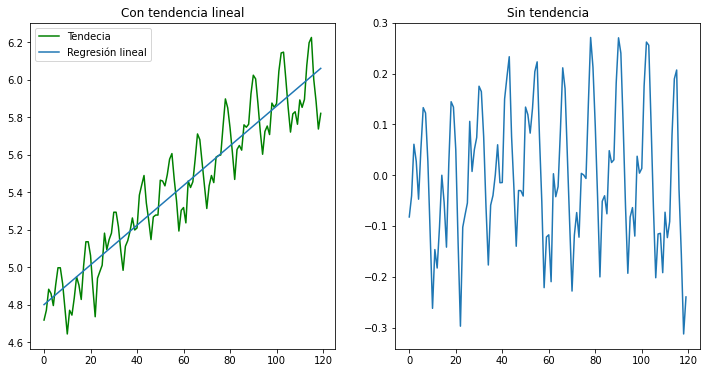

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

ax1.plot(df_train.no_heterocedasticidad, color='green', label='Tendecia')
ax1.plot(y_pred, label = 'Regresión lineal')
ax1.set_title('Con tendencia lineal')
ax1.legend()

ax2.plot(df_train.no_tendencia)
ax2.set_title('Sin tendencia')

plt.show()

### 1.1.c. Estacionalidad

Definimos la estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar y eliminar la estacionalidad. 

#### 1.1.c.a. Encontrar el periodo de la estacionalidad

In [13]:
def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

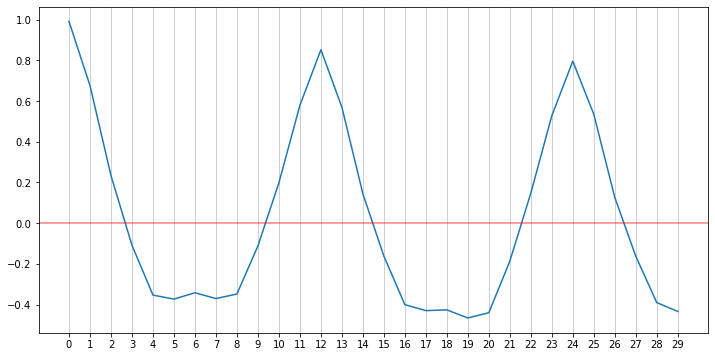

In [14]:
r = estimated_autocorrelation(df_train.no_tendencia)

plt.figure(figsize=(12,6))
plt.plot(r[:30])
plt.grid(axis='x', alpha=0.75)
plt.axhline(0, color='red', alpha=0.5)
plt.xticks(range(0,30))
plt.show()

Se observa en el gráfico que cuando los valores de la autocorrelación llegan a cero, existe un intervalo de 12 puntos de separación entre ellos, por lo tanto la estacionalidad es de 12.

In [15]:
df_train.head(5)

,passengers,no_heterocedasticidad,tendencia,no_tendencia
0,112,4.718499,4.800828,-0.082329
1,118,4.770685,4.811409,-0.040724
2,132,4.882802,4.821989,0.060813
3,129,4.859812,4.832569,0.027243
4,121,4.795791,4.843149,-0.047359


#### 1.1.c.b. Calcular el patron de estacionalidad

In [16]:
seasonality = 12

median_1 = np.zeros(seasonality)
for j in range(0, seasonality):
    median_1[j] = df_train['no_tendencia'][j::seasonality].median()
median_1

array([-0.07584433, -0.08911061,  0.04270543,  0.00214733, -0.01052846,
        0.10944252,  0.19833414,  0.20982956,  0.07513886, -0.06240464,
       -0.21177407, -0.10916743])

In [17]:
seasonal_results = np.zeros(len(df_train))
for j in range(0, 12):
    seasonal_results[j::seasonality] = median_1[j]

In [18]:
df_train['estacionalidad'] = seasonal_results
df_train['no_estacionalidad'] = df_train['no_tendencia'] - df_train['estacionalidad']

Una vez que se resto la heterocedasticidad, la tendecia y el estacionalidad, el resultado es el ruido.

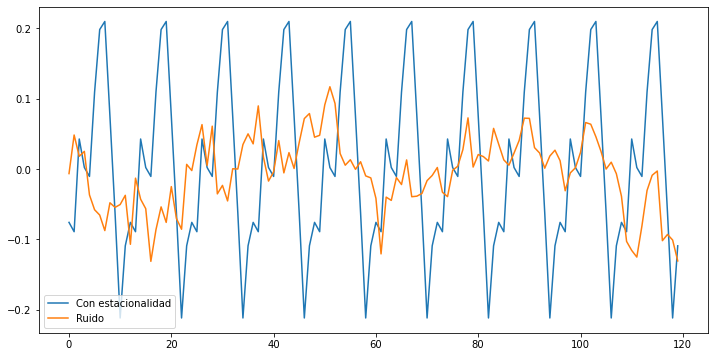

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df_train.estacionalidad, label ='Con estacionalidad')
plt.plot(df_train.no_estacionalidad, label = 'Ruido')
plt.legend()

### 1.1.d. Ruido

Una vez eliminadas la heterocedasticidad, la tendencia y la estacionalidad, lo que nos queda es el ruido. El ruido sigue una distribución normal. En este apartado debeis encontrar los parámetros de la distribución que sigue el ruido (media y desviación estandard).

Para probar que el ruido tiene una distribución normal se utiliza el test de Shapiro-Wilks.

In [20]:
import scipy.stats as stats

shapiro_test = stats.shapiro(df_train.no_estacionalidad)
shapiro_test

ShapiroResult(statistic=0.981512188911438, pvalue=0.09841540455818176)

El valor de p-values es mayor que 0.05, por lo que se rechaza la hipótesis nula, es, decir, se asume que el ruido sigue una distribución normal.

<AxesSubplot:xlabel='no_estacionalidad', ylabel='Density'>

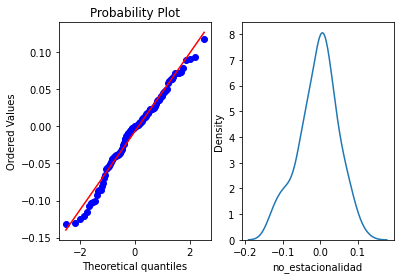

In [21]:
import pylab
import seaborn as sns

plt.subplot(1,2,1)
stats.probplot(df_train.no_estacionalidad, plot=pylab)

plt.subplot(1,2,2)
sns.kdeplot(df_train.no_estacionalidad)

In [22]:
ruido_mean = np.mean(df_train.no_estacionalidad)
ruido_std = np.std(df_train.no_estacionalidad)

ruido_mean, ruido_std

(-0.0065640234271290366, 0.052218958465802136)

En el gráfico de distribución teórica se observa que los puntos están muy cercanos a la línea roja, por lo que podemos asumir que el ruido sigue una distribución normal.

## 1.2. Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Para ello seguiremos los siguientes pasos:

   - Generar ruido
   - Añadir estacionalidad
   - Añadir tendencia
   - Añadir heterocedasticidad

### 1.2.a. Ruido

Como hemos visto que el ruido se distribuye aleatoriamente siguiendo una distribución normal, vamos a generar ruido siguiendo esta distribución.

In [24]:
df_test = pd.DataFrame({'passengers': [int(i) for i in test]}, index = range(120, 144))
df_test.head()

,passengers
120,360
121,342
122,406
123,396
124,420


In [25]:
df_test['ruido'] = np.random.normal(ruido_mean, ruido_std, size=24)
df_test.head()

,passengers,ruido
120,360,-0.078960
121,342,-0.007856
122,406,-0.050628
123,396,-0.064633
124,420,-0.042194


### 1.2.b. Estacionalidad

Anteriormente hemos calculado la estacionalidad y el ciclo de la serie temporal. Vamos a usar esta estacionalidad ya calculada para añadirla a nuestra predicción.

Para predecir los siguientes 24 puntos, se tomarán los 24 últimos registros del dataset de train. Esto se debe a que 

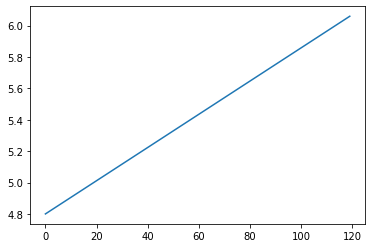

In [26]:
plt.plot(df_train.tendencia)

In [27]:
df_test['ruido_estacionalidad'] = df_test['ruido'] + np.array(df_train[-24:]['estacionalidad'])
df_test.head()

,passengers,ruido,ruido_estacionalidad
120,360,-0.078960,-0.154804
121,342,-0.007856,-0.096967
122,406,-0.050628,-0.007923
123,396,-0.064633,-0.062485
124,420,-0.042194,-0.052722


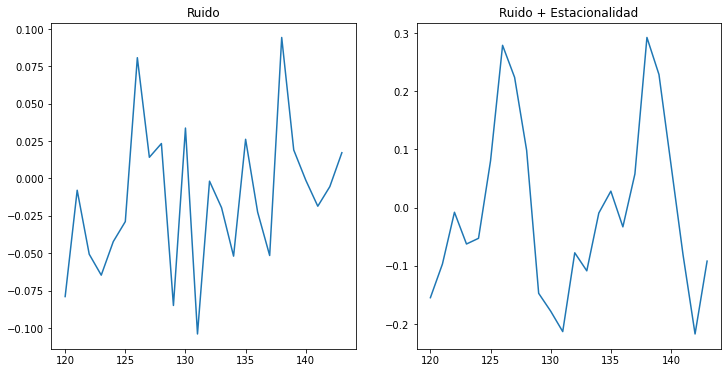

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

ax1.plot(df_test['ruido'])
ax1.set_title('Ruido')

ax2.plot(df_test['ruido_estacionalidad'])
ax2.set_title('Ruido + Estacionalidad')

plt.show()

### 1.2.c. Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

In [29]:
df_test['ruido_estacionalidad_tendencia'] = df_test['ruido_estacionalidad'] + np.array(df_train[-24:]['tendencia'])

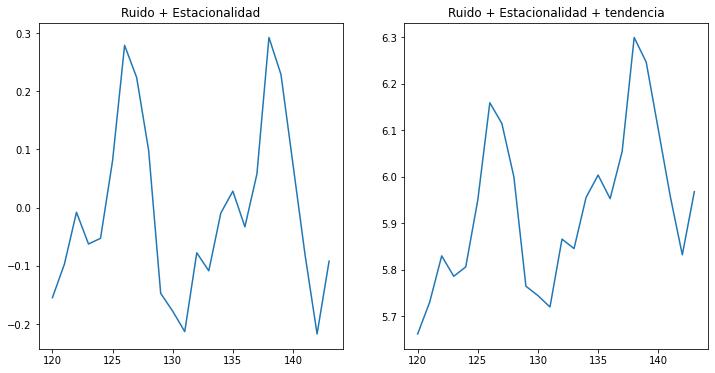

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

ax1.plot(df_test['ruido_estacionalidad'])
ax1.set_title('Ruido + Estacionalidad')

ax2.plot(df_test['ruido_estacionalidad_tendencia'])
ax2.set_title('Ruido + Estacionalidad + tendencia')

plt.show()

### 1.2.d. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

In [31]:
rr= np.exp(np.array(df_train[-24:]['no_heterocedasticidad']))
# rr= np.array(df_train[-24:]['passengers'])
df_test['ruido_estacionalidad_tendencia_heterocedasticidad'] = df_test['ruido_estacionalidad_tendencia']  + rr

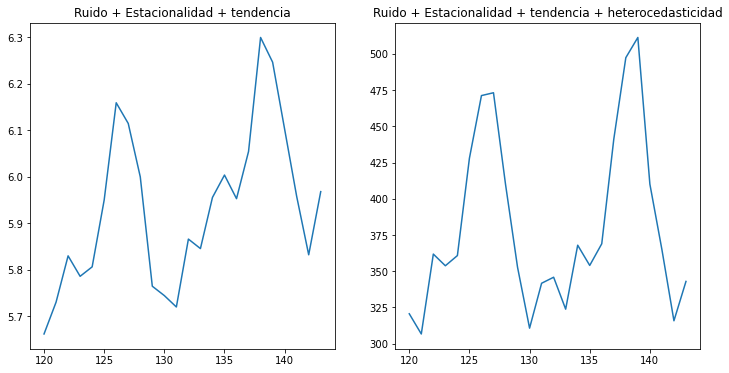

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

ax1.plot(df_test['ruido_estacionalidad_tendencia'])
ax1.set_title('Ruido + Estacionalidad + tendencia')

ax2.plot(df_test['ruido_estacionalidad_tendencia_heterocedasticidad'])
ax2.set_title('Ruido + Estacionalidad + tendencia + heterocedasticidad')

plt.show()

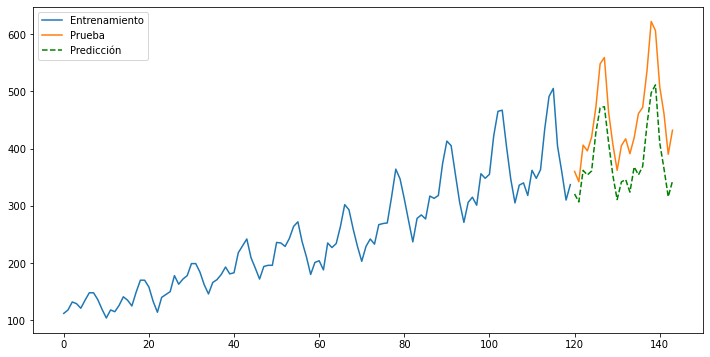

In [33]:
plt.figure(figsize=(12,6))
plt.plot(df_train.passengers, label = 'Entrenamiento')
plt.plot(df_test.passengers, label ='Prueba')
plt.plot(df_test.ruido_estacionalidad_tendencia_heterocedasticidad, 'g--',label = 'Predicción')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error

result = mean_absolute_error(df_test.passengers, df_test.ruido_estacionalidad_tendencia_heterocedasticidad)
result

71.6104507112783

El valor de MAE es de 71 pasajeros. Por lo tanto, en promedio, habrá 71 pasajeros por encima o por debajo del valor real.